In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# individual_turnover = pd.read_csv("../data/ind_turnover.csv")
# print(individual_turnover.columns.tolist())
# individual_turnover.head(3)

In [3]:
turnover_trend = pd.read_csv("../data/10yr_turnover.csv")
print(turnover_trend.columns.tolist())
turnover_trend.head(3)

['EmployeeID', 'recorddate_key', 'birthdate_key', 'orighiredate_key', 'terminationdate_key', 'age', 'length_of_service', 'city_name', 'department_name', 'job_title', 'store_name', 'gender_short', 'gender_full', 'termreason_desc', 'termtype_desc', 'STATUS_YEAR', 'STATUS', 'BUSINESS_UNIT']


,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT
0,1318,12/31/2006 0:00,1/3/1954,8/28/1989,1/1/1900,52,17,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2006,ACTIVE,HEADOFFICE
1,1318,12/31/2007 0:00,1/3/1954,8/28/1989,1/1/1900,53,18,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2007,ACTIVE,HEADOFFICE
2,1318,12/31/2008 0:00,1/3/1954,8/28/1989,1/1/1900,54,19,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2008,ACTIVE,HEADOFFICE


In [4]:
def preprocess_turnover_data(turnover_trend):
    turnover_trend['year'] = pd.to_datetime(turnover_trend['recorddate_key']).dt.to_period('Y')

    turnover_trend.columns = [col.lower() for col in turnover_trend.columns]
    # get dummies for all categoricals, drop originals
    categorical_features = ['job_title', 'gender_short', 'termreason_desc', 'termtype_desc', 'business_unit',  'department_name']
    turnover_trend = pd.get_dummies(turnover_trend, columns=categorical_features, drop_first=False)
    turnover_trend.columns = [col.lower() for col in turnover_trend.columns]

    # 1 = voluntary turnover, 0 = stayed
    turnover_trend['voluntary_turnover'] = (turnover_trend['termreason_desc_resignaton'] == True).astype(int)

    # drop any unnecessary columns
    i=0
    drop_cols = ['termreason_desc_layoff',
                'termreason_desc_not applicable',
                'termreason_desc_resignaton',
                'termreason_desc_retirement',
                'termtype_desc_involuntary',
                'termtype_desc_not applicable',
                'termtype_desc_voluntary']

    for each in turnover_trend.dtypes:
        if each == 'object':
            drop_cols.append(turnover_trend.columns[i])
        i+=1

    # remove potential model by columns from drop_cols
    model_by_cols = ['city_name', 'store_name']
    drop_cols = [col for col in drop_cols if col not in model_by_cols]
    turnover_trend.drop(columns=drop_cols+['employeeid','status_year'], inplace=True)
    
    return turnover_trend

def yearify_features(df):
    """Convert features to yearly averages or sums as appropriate."""
    df = df.copy()
    df.drop(columns=['city_name', 'store_name'], inplace=True)
    df = df.groupby('year').mean(numeric_only=False)
    return df

def city_store_yearify(df):
    """Convert features to yearly averages or sums as appropriate."""
    df = df.copy()
    df = df.groupby(['year', 'city_name', 'store_name']).mean(numeric_only=False)
    return df

In [5]:
preprocessed_turnover_trend = preprocess_turnover_data(turnover_trend)
year_df = yearify_features(preprocessed_turnover_trend)
city_store_yr_df = city_store_yearify(preprocessed_turnover_trend)

In [6]:
preprocessed_turnover_trend.head(3) 

,age,length_of_service,city_name,store_name,year,job_title_accounting clerk,job_title_accounts payable clerk,job_title_accounts receiveable clerk,job_title_auditor,job_title_baker,...,department_name_investment,department_name_labor relations,department_name_legal,department_name_meats,department_name_processed foods,department_name_produce,department_name_recruitment,department_name_store management,department_name_training,voluntary_turnover
0,52,17,Vancouver,35,2006,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1,53,18,Vancouver,35,2007,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2,54,19,Vancouver,35,2008,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0


In [7]:
year_df.head(3)

,age,length_of_service,job_title_accounting clerk,job_title_accounts payable clerk,job_title_accounts receiveable clerk,job_title_auditor,job_title_baker,job_title_bakery manager,job_title_benefits admin,job_title_ceo,...,department_name_investment,department_name_labor relations,department_name_legal,department_name_meats,department_name_processed foods,department_name_produce,department_name_recruitment,department_name_store management,department_name_training,voluntary_turnover
year,,,,,,,,,,,,,,,,,,,,,
2006,43.749727,8.262066,0.001092,0.000655,0.000874,0.000655,0.178205,0.007207,0.001092,0.000218,...,0.000874,0.001310,0.000655,0.259445,0.074470,0.223848,0.001965,0.007644,0.001092,0.002621
2007,43.270767,8.730942,0.001068,0.000641,0.000854,0.000641,0.174674,0.007047,0.001068,0.000214,...,0.000854,0.001281,0.000641,0.241512,0.087551,0.208840,0.001922,0.007474,0.001068,0.005338
2008,42.669184,9.158800,0.001049,0.000629,0.000839,0.000629,0.171387,0.006923,0.001049,0.000210,...,0.000839,0.001259,0.000629,0.229285,0.105307,0.192993,0.001888,0.007342,0.001049,0.005454


In [8]:
city_store_yr_df.head(3)

age  length_of_service  \
year city_name   store_name                                 
2006 Abbotsford  1           43.833333           7.833333   
     Aldergrove  2           44.444444           8.355556   
     Bella Bella 3           39.916667           6.833333   

                             job_title_accounting clerk  \
year city_name   store_name                               
2006 Abbotsford  1                                  0.0   
     Aldergrove  2                                  0.0   
     Bella Bella 3                                  0.0   

                             job_title_accounts payable clerk  \
year city_name   store_name                                     
2006 Abbotsford  1                                        0.0   
     Aldergrove  2                                        0.0   
     Bella Bella 3                                        0.0   

                             job_title_accounts receiveable clerk  \
year city_name   store_name                                         
2006 Abbotsford  1                                            0.0   
     Aldergrove  2                                            0.0   
     Bella Bella 3                                            0.0   

                             job_title_auditor  job_title_baker  \
year city_name   store_name                                       
2006 Abbotsford  1                         0.0         0.183333   
     Aldergrove  2                         0.0         0.244444   
     Bella Bella 3                         0.0         0.166667   

                             job_title_bakery manager  \
year city_name   store_name                             
2006 Abbotsford  1                           0.016667   
     Aldergrove  2                           0.000000   
     Bella Bella 3                           0.000000   

                             job_title_benefits admin  job_title_ceo  ...  \
year city_name   store_name                                           ...   
2006 Abbotsford  1                                0.0            0.0  ...   
     Aldergrove  2                                0.0            0.0  ...   
     Bella Bella 3                                0.0            0.0  ...   

                             department_name_investment  \
year city_name   store_name                               
2006 Abbotsford  1                                  0.0   
     Aldergrove  2                                  0.0   
     Bella Bella 3                                  0.0   

                             department_name_labor relations  \
year city_name   store_name                                    
2006 Abbotsford  1                                       0.0   
     Aldergrove  2                                       0.0   
     Bella Bella 3                                       0.0   

                             department_name_legal  department_name_meats  \
year city_name   store_name                                                 
2006 Abbotsford  1                             0.0               0.316667   
     Aldergrove  2                             0.0               0.244444   
     Bella Bella 3                             0.0               0.166667   

                             department_name_processed foods  \
year city_name   store_name                                    
2006 Abbotsford  1                                  0.116667   
     Aldergrove  2                                  0.022222   
     Bella Bella 3                                  0.000000   

                             department_name_produce  \
year city_name   store_name                            
2006 Abbotsford  1                          0.316667   
     Aldergrove  2                          0.377778   
     Bella Bella 3                          0.166667   

                             department_name_recruitment  \
year city_name   store_name                                
2006 Abbotsford  1          

In [9]:
city_store_df[city_store_df['business_unit_headoffice']>0]

NameError: name 'city_store_df' is not defined

In [ ]:
turnover_trend

,employeeid,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,status_year,status,business_unit,year
0,1318,12/31/2006 0:00,1/3/1954,8/28/1989,1/1/1900,52,17,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2006,ACTIVE,HEADOFFICE,2006
1,1318,12/31/2007 0:00,1/3/1954,8/28/1989,1/1/1900,53,18,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2007,ACTIVE,HEADOFFICE,2007
2,1318,12/31/2008 0:00,1/3/1954,8/28/1989,1/1/1900,54,19,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2008,ACTIVE,HEADOFFICE,2008
3,1318,12/31/2009 0:00,1/3/1954,8/28/1989,1/1/1900,55,20,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2009,ACTIVE,HEADOFFICE,2009
4,1318,12/31/2010 0:00,1/3/1954,8/28/1989,1/1/1900,56,21,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2010,ACTIVE,HEADOFFICE,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49648,8258,12/1/2015 0:00,5/28/1994,8/19/2013,12/30/2015,21,2,Valemount,Dairy,Dairy Person,34,M,Male,Layoff,Involuntary,2015,TERMINATED,STORES,2015
49649,8264,8/1/2013 0:00,6/13/1994,8/27/2013,8/30/2013,19,0,Vancouver,Customer Service,Cashier,44,F,Female,Resignaton,Voluntary,2013,TERMINATED,STORES,2013
49650,8279,12/1/2015 0:00,7/18/1994,9/15/2013,12/30/2015,21,2,White Rock,Customer Service,Cashier,39,F,Female,Layoff,Involuntary,2015,TERMINATED,STORES,2015
49651,8296,12/1/2013 0:00,9/2/1994,10/9/2013,12/31/2013,19,0,Kelowna,Customer Service,Cashier,16,F,Female,Resignaton,Voluntary,2013,TERMINATED,STORES,2013


# EDA

In [ ]:
def plot_turnover_comparison(feature_col, feature_values, feature_labels=None, title_suffix=""):

    if feature_labels is None:
        feature_labels = [str(val) for val in feature_values]

    # Filter data for the two groups
    group1_data = preprocessed_turnover_trend[preprocessed_turnover_trend[feature_col] == feature_values[0]]

    if len(feature_values) != 2:
        group2_data = preprocessed_turnover_trend[preprocessed_turnover_trend[feature_col] != feature_values[0]]
    else:
        group2_data = preprocessed_turnover_trend[preprocessed_turnover_trend[feature_col] == feature_values[1]]
    
    # Calculate turnover rates by year for each group
    group1_turnover_by_year = group1_data.groupby('year')['voluntary_turnover'].mean()
    if len(feature_values) != 2:
        group2_turnover_by_year = group2_data.groupby('year')['voluntary_turnover'].mean()
    else:
        group2_turnover_by_year = group2_data.groupby('year')['voluntary_turnover'].mean()
    
    # Create the plot
    plt.figure(figsize=(5, 4))
    group1_turnover_by_year.plot(kind='line', marker='o', label=feature_labels[0], linewidth=2)
    group2_turnover_by_year.plot(kind='line', marker='s', label=feature_labels[1], linewidth=2)
    
    plt.title(f'Voluntary Turnover Rate by Year: {feature_labels[0]} vs {feature_labels[1]}{title_suffix}')
    plt.xlabel('Year')
    plt.ylabel('Voluntary Turnover Rate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"{feature_labels[0]} Average Turnover Rate:", group1_turnover_by_year.mean())
    print(f"{feature_labels[1]} Average Turnover Rate:", group2_turnover_by_year.mean())

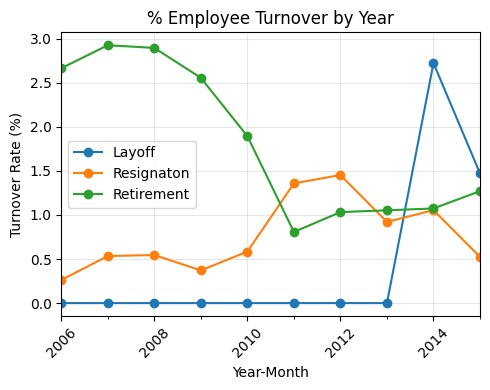

In [ ]:
monthly_turnover_by_reason = turnover_trend.groupby(['year', 'termreason_desc']).size().unstack(fill_value=0)
total_workforce_by_year = turnover_trend.groupby('year').size()
monthly_turnover_pct_by_reason = (monthly_turnover_by_reason.div(total_workforce_by_year, axis=0) * 100)
monthly_turnover_pct_by_reason.drop(columns=['Not Applicable'], inplace=True)

# Create the plot
plt.figure(figsize=(5, 4))
for reason in monthly_turnover_pct_by_reason.columns:
    monthly_turnover_pct_by_reason[reason].plot(kind='line', marker='o', label=reason)

plt.title('Employee Turnover by Year')
plt.xlabel('Year')
plt.ylabel('Turnover Rate (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


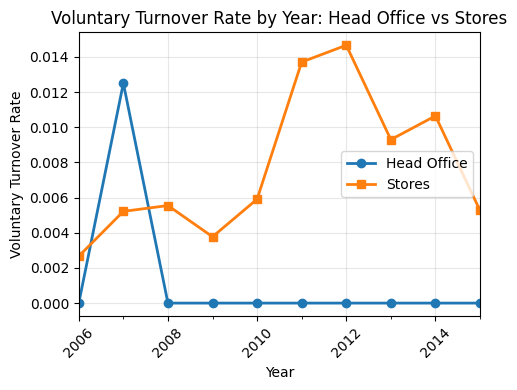

Head Office Average Turnover Rate: 0.00125
Stores Average Turnover Rate: 0.007667335559651362


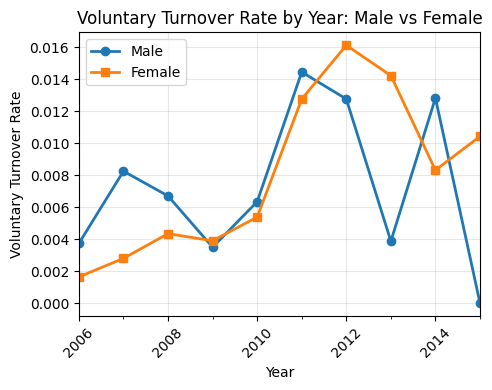

Male Average Turnover Rate: 0.007249217475824482
Female Average Turnover Rate: 0.00799795499761738


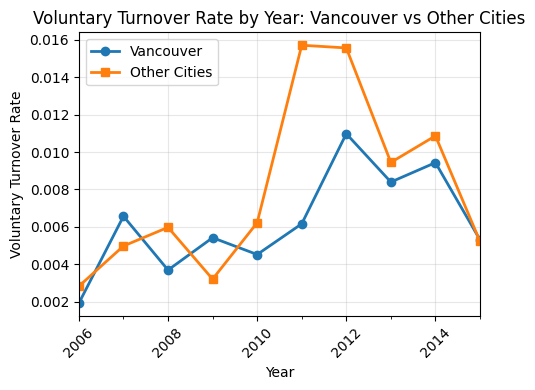

Vancouver Average Turnover Rate: 0.00623975770497936
Other Cities Average Turnover Rate: 0.0080015672512572


In [26]:
plot_turnover_comparison('business_unit_headoffice', [True, False], ['Head Office', 'Stores'])
plot_turnover_comparison('gender_short_f', [False, True], ['Male', 'Female'])
plot_turnover_comparison('city_name', ['Vancouver'], ['Vancouver', 'Other Cities'])

In [49]:
turnover_trend['voluntary_turnover'] = (turnover_trend['termreason_desc']=='Resignation')

In [50]:
turnover_trend['voluntary_turnover'] 

0        False
1        False
2        False
3        False
4        False
         ...  
49648    False
49649    False
49650    False
49651    False
49652    False
Name: voluntary_turnover, Length: 49653, dtype: bool

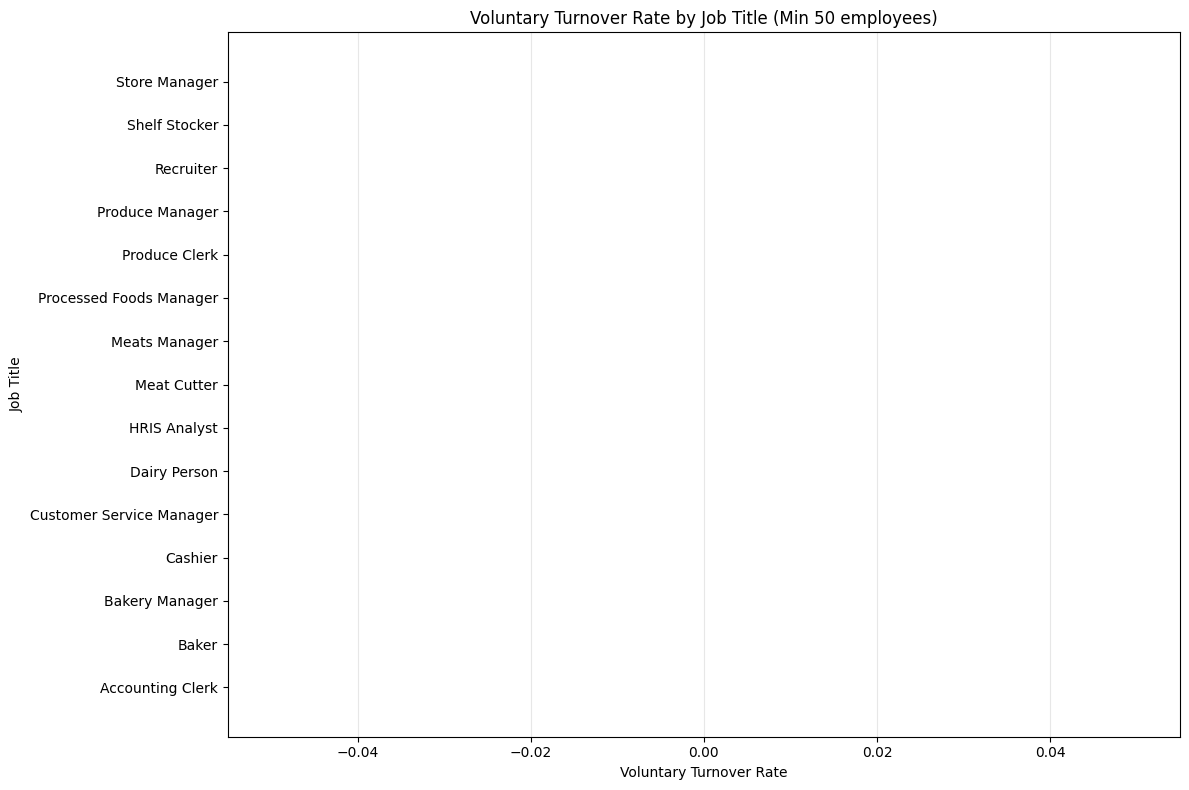

Top 10 Job Titles by Turnover Rate:
                   job_title  turnover_rate  total_employees
0           Accounting Clerk            0.0               50
4                      Baker            0.0             8096
5             Bakery Manager            0.0              285
9                    Cashier            0.0             6816
12  Customer Service Manager            0.0              306
14              Dairy Person            0.0             8590
30              HRIS Analyst            0.0               55
34               Meat Cutter            0.0             9984
35             Meats Manager            0.0              285
36   Processed Foods Manager            0.0              289


In [47]:
# Get turnover rates by job title
job_title_turnover = turnover_trend.groupby('job_title')['voluntary_turnover'].agg(['count', 'sum', 'mean']).reset_index()
job_title_turnover.columns = ['job_title', 'total_employees', 'total_turnover', 'turnover_rate']

# Sort by turnover rate and filter for job titles with reasonable sample sizes
job_title_turnover = job_title_turnover[job_title_turnover['total_employees'] >= 50]
job_title_turnover = job_title_turnover.sort_values('turnover_rate', ascending=False)

# Create the plot
plt.figure(figsize=(12, 8))
plt.barh(job_title_turnover['job_title'], job_title_turnover['turnover_rate'])
plt.xlabel('Voluntary Turnover Rate')
plt.ylabel('Job Title')
plt.title('Voluntary Turnover Rate by Job Title (Min 50 employees)')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Display the data
print("Top 10 Job Titles by Turnover Rate:")
print(job_title_turnover.head(10)[['job_title', 'turnover_rate', 'total_employees']])